In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from visutils import *
from camutils import *
from meshutils import *
from decode_reconstruct import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [13]:
file = open('calibration.pickle', 'rb')

data = pickle.load(file)

file.close()

print('Showing the pickle data:')
for key, val in data.items():
    print(key, ': ', val)

Showing the pickle data:
my_f :  2933.7009224327835
my_c :  [2092.58266801 1475.24797147]
fx :  2941.8139632464286
fy :  2925.5878816191384
cx :  2092.582668012995
cy :  1475.247971466617
K :  [[2.94181396e+03 0.00000000e+00 2.09258267e+03]
 [0.00000000e+00 2.92558788e+03 1.47524797e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist :  [[ 0.15324087 -0.73367413 -0.00311988  0.00757166  0.91412386]]


In [14]:
my_f = data["my_f"]
my_c = data["my_c"].reshape(2, 1)
t = np.array([[0, 0, 0]]).T
R = makerotation(0, 0, 0)

C0 = Camera(my_f, my_c, R, t)
C1 = Camera(my_f, my_c, R, t)

In [15]:
img_C0 = plt.imread('../photos/Calibration/frame_C0_01.jpg')
_, corners0 = cv2.findChessboardCorners(img_C0, (8,6), None) 
pts2_C0 = corners0.squeeze().T

img_C1 = plt.imread('../photos/Calibration/frame_C1_01.jpg')
_, corners1 = cv2.findChessboardCorners(img_C1, (8,6), None) 
pts2_C1 = corners1.squeeze().T

pts3 = np.zeros((3, 6*8))
y_coords,x_coords = np.meshgrid(np.arange(8), np.arange(6)) 
pts3[0,:] = 3 * x_coords.reshape(1, -1)
pts3[1,:] = 3 * y_coords.reshape(1, -1)

In [16]:
params_init_C0 = np.array([0, 0, 0, 0, 0, -2]) 
params_init_C1 = np.array([0, 0, 0, 0, 0, -2])

C0 = calibratePose(pts3, pts2_C0, C0, params_init_C0) 
C1 = calibratePose(pts3, pts2_C1, C1, params_init_C1)

print(C0, C1)

Camera : 
 f=2933.7009224327835 
 c=[[2092.58266801 1475.24797147]] 
 R=[[-6.39159965e-02  9.97343106e-01 -3.49495892e-02]
 [ 9.97953344e-01  6.39456868e-02 -2.68746360e-04]
 [ 1.96684316e-03 -3.48952366e-02 -9.99389040e-01]] 
 t = [[-1.32461114 16.96146787 46.96543911]] Camera : 
 f=2933.7009224327835 
 c=[[2092.58266801 1475.24797147]] 
 R=[[-0.0667051   0.99705529 -0.03783104]
 [ 0.98512658  0.05979482 -0.16109066]
 [-0.15835419 -0.04801393 -0.98621428]] 
 t = [[-1.22386827 28.78578452 44.96380952]]


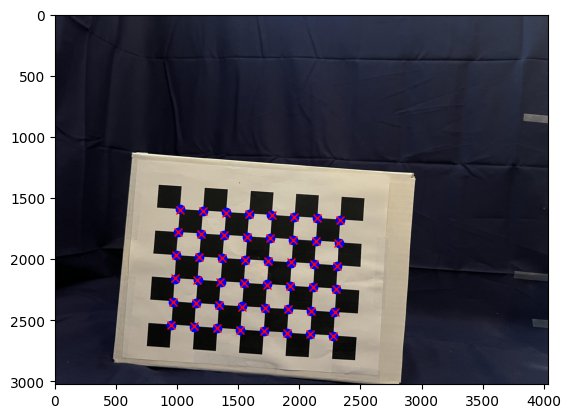

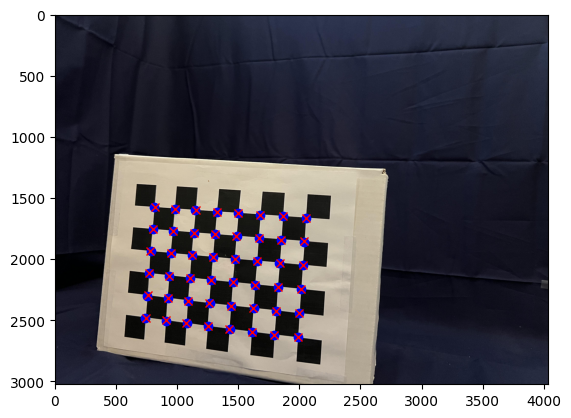

In [17]:
plt.figure()
project_pts2_C0 = C0.project(pts3)
plt.imshow(img_C0)
plt.plot(project_pts2_C0[0,:], project_pts2_C0[1,:],'bo')
plt.plot(pts2_C0[0,:], pts2_C0[1,:],'rx')
plt.show()

plt.figure()
project_pts2_C1 = C1.project(pts3)
plt.imshow(img_C1)
plt.plot(project_pts2_C1[0,:], project_pts2_C1[1,:],'bo')
plt.plot(pts2_C1[0,:], pts2_C1[1,:],'rx')
plt.show()

# PROJECTIONS vv

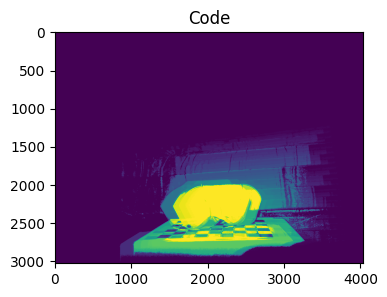

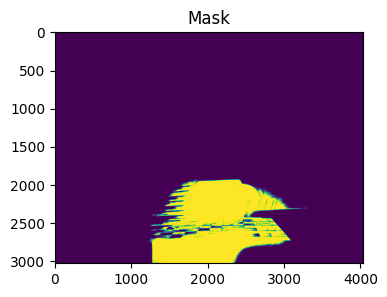

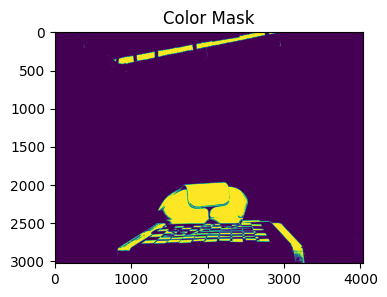

In [ ]:
# mess around with thresholds and how they look like w other grabs/cameras
threshold_color = 0.5
threshold = 0.45
start = 0
code, mask, color_mask = decode('../photos/Captures/grab5/color_C0_', '../photos/Captures/grab5/frame_C0_', \
                                 start, threshold_color, threshold)

# code, mask, color_mask = decode('../photos/Captures/grab3/color_C0_', '../photos/Captures/grab3/frame_C0_', \
#                                   start, threshold_color, threshold)

plt.figure(figsize=(4,3))
plt.imshow(code)
plt.title("Code")

plt.figure(figsize=(4,3))
plt.imshow(mask)
plt.title("Mask")

plt.figure(figsize=(4,3))
plt.imshow(color_mask)
plt.title("Color Mask")

plt.show()


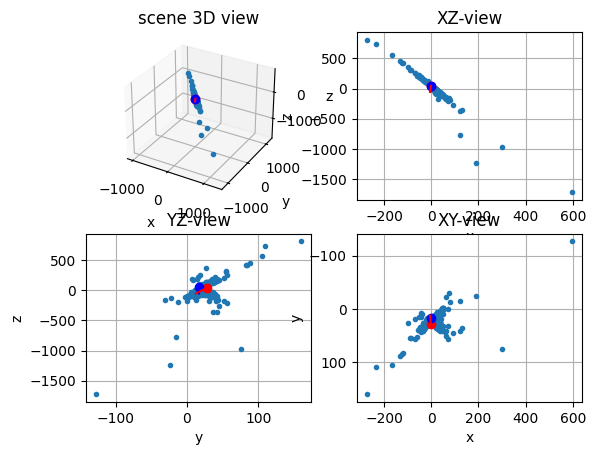

In [19]:
# first mesh test (grab5 gave best results)
imprefix_co_C0 = '../photos/Captures/grab5/color_C0_'
imprefix_fr_C0 = '../photos/Captures/grab5/frame_C0_'
imprefix_co_C1 = '../photos/Captures/grab5/color_C1_'
imprefix_fr_C1 = '../photos/Captures/grab5/frame_C1_'

color_thresh=0.5
v_thresh=0.2
h_thresh=0.45

pts2L,pts2R,pts3,bvalues = reconstruct(imprefix_co_C0,imprefix_fr_C0,imprefix_co_C1,imprefix_fr_C1,\
                                        color_thresh,v_thresh,h_thresh,\
                                        C0,C1)

vis_scene(C0, C1, pts3, looklength=100)


Number of triangles before filtering: 540
Number of triangles after filtering: 96


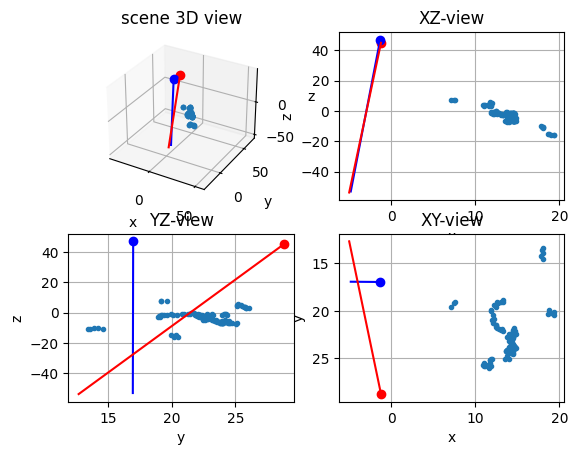

In [20]:
# bounding box
blim = np.array([-50,50,-50,50,-50,50])
triangle_thresh=0.95

# filter now
pts3,tri,bvalues,Triangles = meshgeneration(pts2L, pts2R, pts3, bvalues, blim, triangle_thresh)

vis_scene(C0, C1, pts3, looklength=100)

print("Number of triangles before filtering:", Triangles.simplices.shape[0])
print("Number of triangles after filtering:", tri.shape[0])


In [21]:

num_grabs = 5

for i in range(1, num_grabs+1):
    imprefix_co_C0 = f'../photos/Captures/grab{i}/color_C0_'
    imprefix_fr_C0 = f'../photos/Captures/grab{i}/frame_C0_'
    imprefix_co_C1 = f'../photos/Captures/grab{i}/color_C1_'
    imprefix_fr_C1 = f'../photos/Captures/grab{i}/frame_C1_'

    outfile = f'grab{i}.ply'

    color_thresh = 0.5
    v_thresh = 0.2
    h_thresh = 0.45

    pts2L, pts2R, pts3, bvalues = reconstruct(imprefix_co_C0, imprefix_fr_C0, imprefix_co_C1, imprefix_fr_C1,\
                                            color_thresh, v_thresh, h_thresh,\
                                            C0, C1)

    blim = np.array([-50,50,-50,50,-50,50])
    triangle_thresh = 0.95

    pts3, tri, bvalues,_ = meshgeneration(pts2L, pts2R, pts3, bvalues, blim, triangle_thresh)

    writeply(pts3, bvalues, tri, outfile)